In [21]:
import deep_predictor
from collections.abc import Mapping
import torch
import scanpy as sc

In [22]:
import scipy.stats as ss
import numpy as np
import scipy.stats as ss
sc.set_figure_params(dpi=250, color_map='viridis')  # low dpi (dots per inch) yields small inline figures
import pandas as pd

In [23]:
import numpy as np
import pandas as pd

In [24]:
adata = sc.read_h5ad("/home/gaurav/Gaurav/Berlin/Deep_Learning/pytorchVAE/Larry_data/Neutrophil_monocyte/larry_hema_training_data.h5ad")

In [25]:
adata_segment_22 = adata[adata.obs["segment"] == 22] #Monocyte
adata_segment_25 = adata[adata.obs["segment"] == 25] #Neutrophil

In [26]:
training_data = adata_segment_22[(adata_segment_22.obs["pseudotime"] <= 0.1) | (adata_segment_22.obs["pseudotime"] > 0.3)]
training_data.obs["cells"] = "Training data"
training_data.obs["data"] = (training_data.obs["pseudotime"] > 0.3).astype('uint8') 

/tmp/ipykernel_24733/2729020257.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  training_data.obs["cells"] = "Training data"


In [79]:
zebra_obj = deep_predictor.DeepPredictor(training_data,latent_dim=100,hidden_layers=[800,800],workers=8,parameters=[0,0,0,1,1],likelihood="nb",batch_size=100)

In [80]:
zebra_obj.reload_model(path="/home/gaurav/Gaurav/Berlin/Deep_Learning/Project/models/NB_MMD/withouttestdata/Hema_monocyte_trained/model_200.pt")


In [81]:
zebra_obj.runFlows(1,0,"data")

In [82]:
zebra_obj.trainFlows(iterations=0)

In [83]:
test_subset = adata_segment_25[(adata_segment_25.obs["pseudotime"] <= 0.1) | (adata_segment_25.obs["pseudotime"] > 0.3)]
test_subset.obs["data"] = (test_subset.obs["pseudotime"] > 0.3).astype('uint8') 
Test_data = test_subset[test_subset.obs["data"] == 1]
Test_data.obs["cells"] = "Test data"
Real_data = test_subset[test_subset.obs["data"] == 0]
Real_data.obs["cells"] = "Real data"

/tmp/ipykernel_24733/93377785.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  test_subset.obs["data"] = (test_subset.obs["pseudotime"] > 0.3).astype('uint8')
/tmp/ipykernel_24733/93377785.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  Test_data.obs["cells"] = "Test data"
/tmp/ipykernel_24733/93377785.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  Real_data.obs["cells"] = "Real data"


In [84]:
adata_test = Real_data.concatenate(Test_data)

/home/gaurav/anaconda3/envs/project/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [85]:
adata_hema_neutrophil_backward,px_scale,theta,px_rate = zebra_obj.predict(adata_test,1,0,"data")


/home/gaurav/anaconda3/envs/project/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats



def corrfunc(x, y, **kws):
	slope, intercept, r, p_value, _err = stats.linregress(x, y)
	ax = plt.gca()
	ax.annotate("$R^2$ = {:.2f}".format(r**2),
				xy=(.7, .9), xycoords=ax.transAxes)


def Plotting_Correlation_genes(data_object,title,scatter_color):
    real_data = data_object[data_object.obs["cells"] == "Real data",:]
    pred_data =  data_object[data_object.obs["cells"] == "Predicted data",:] 
    scanpy_obj_data = np.vstack((np.average(real_data.X,axis = 0),np.average(pred_data.X,axis = 0)))
    X = "Real data"
    Y = "Predicted data"
    scanpy_obj_data_df = pd.DataFrame(scanpy_obj_data.T,columns=[X,Y])
    corrfunc(scanpy_obj_data[0],scanpy_obj_data[1])
    ax = sns.regplot(data = scanpy_obj_data_df,x = X ,y = Y,scatter=True,scatter_kws={'s':10},marker = "o",color=scatter_color)
    #major_ticks = np.arange(0, 100,20)
    #ax.set_xticks(major_ticks)
    #ax.set_yticks(major_ticks)
    #plt.xlim(0,80) 
    #plt.ylim(0,80)
    plt.grid(False)
    sns.despine(offset=5)
    plt.xlabel(X,fontsize = 20)
    plt.ylabel(Y,fontsize = 20)    
    plt.tick_params(labelsize=20)
    plt.title(title,fontsize = 20)   
    plt.show()
    
def Plotting_Correlation_var(data_object,title,scatter_color):
    real_data = data_object[data_object.obs["cells"] == "Real data",:]
    pred_data =  data_object[data_object.obs["cells"] == "Predicted data",:] 
    scanpy_obj_data = np.vstack((np.std(real_data.X,axis = 0),np.std(pred_data.X,axis = 0)))
    X = "Real data"
    Y = "Predicted data"
    scanpy_obj_data_df = pd.DataFrame(scanpy_obj_data.T,columns=[X,Y])
    corrfunc(scanpy_obj_data[0],scanpy_obj_data[1])
    ax = sns.regplot(data = scanpy_obj_data_df,x = X ,y = Y,scatter=True,scatter_kws={'s':10},marker = "o",color=scatter_color)
    #major_ticks = np.arange(0, 40,5)
    #ax.set_xticks(major_ticks)
    #ax.set_yticks(major_ticks)
    sns.despine(offset=2)
    #plt.xlim(-1,25) 
    #plt.ylim(-1,25)
    plt.grid(False)
    plt.xlabel(X,fontsize = 20)
    plt.ylabel(Y,fontsize = 20)    
    plt.tick_params(labelsize=20)
    plt.title(title,fontsize = 20)
    plt.show()

In [87]:
pca_pal = ["#d62728","#ff7f0e","#1f77b4"]

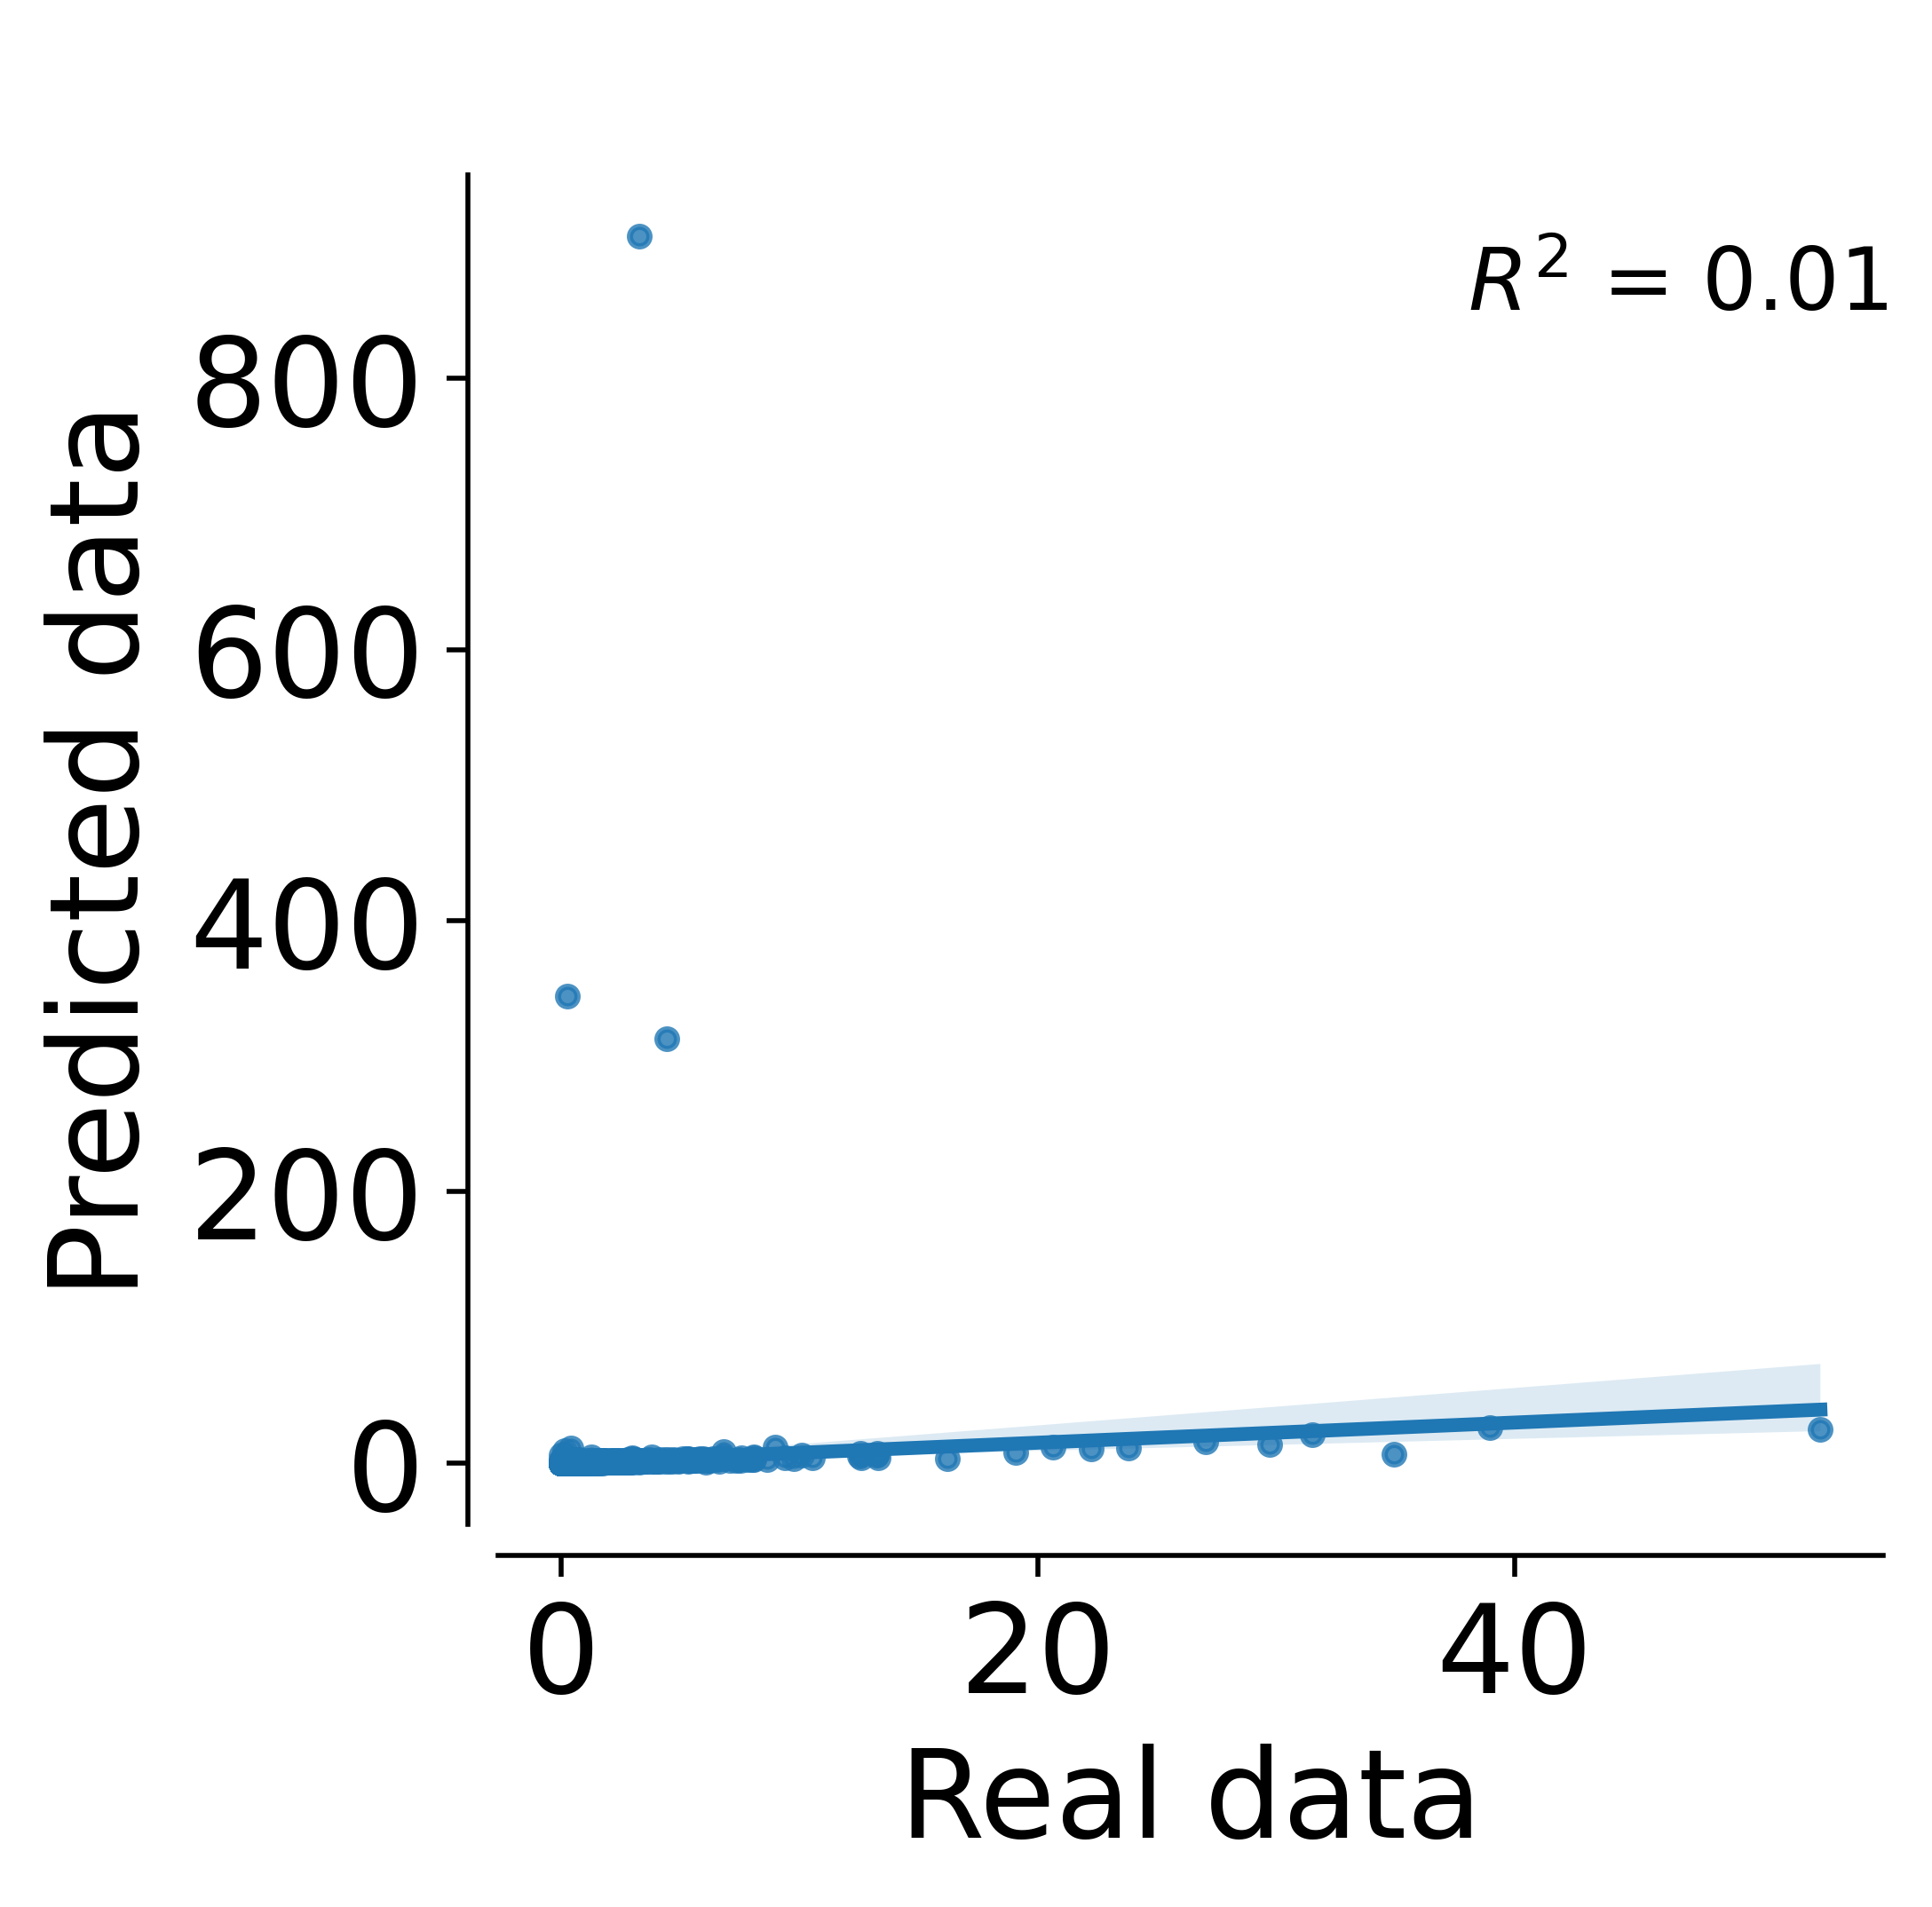

In [88]:
Plotting_Correlation_genes(adata_hema_neutrophil_backward," ",pca_pal[2])


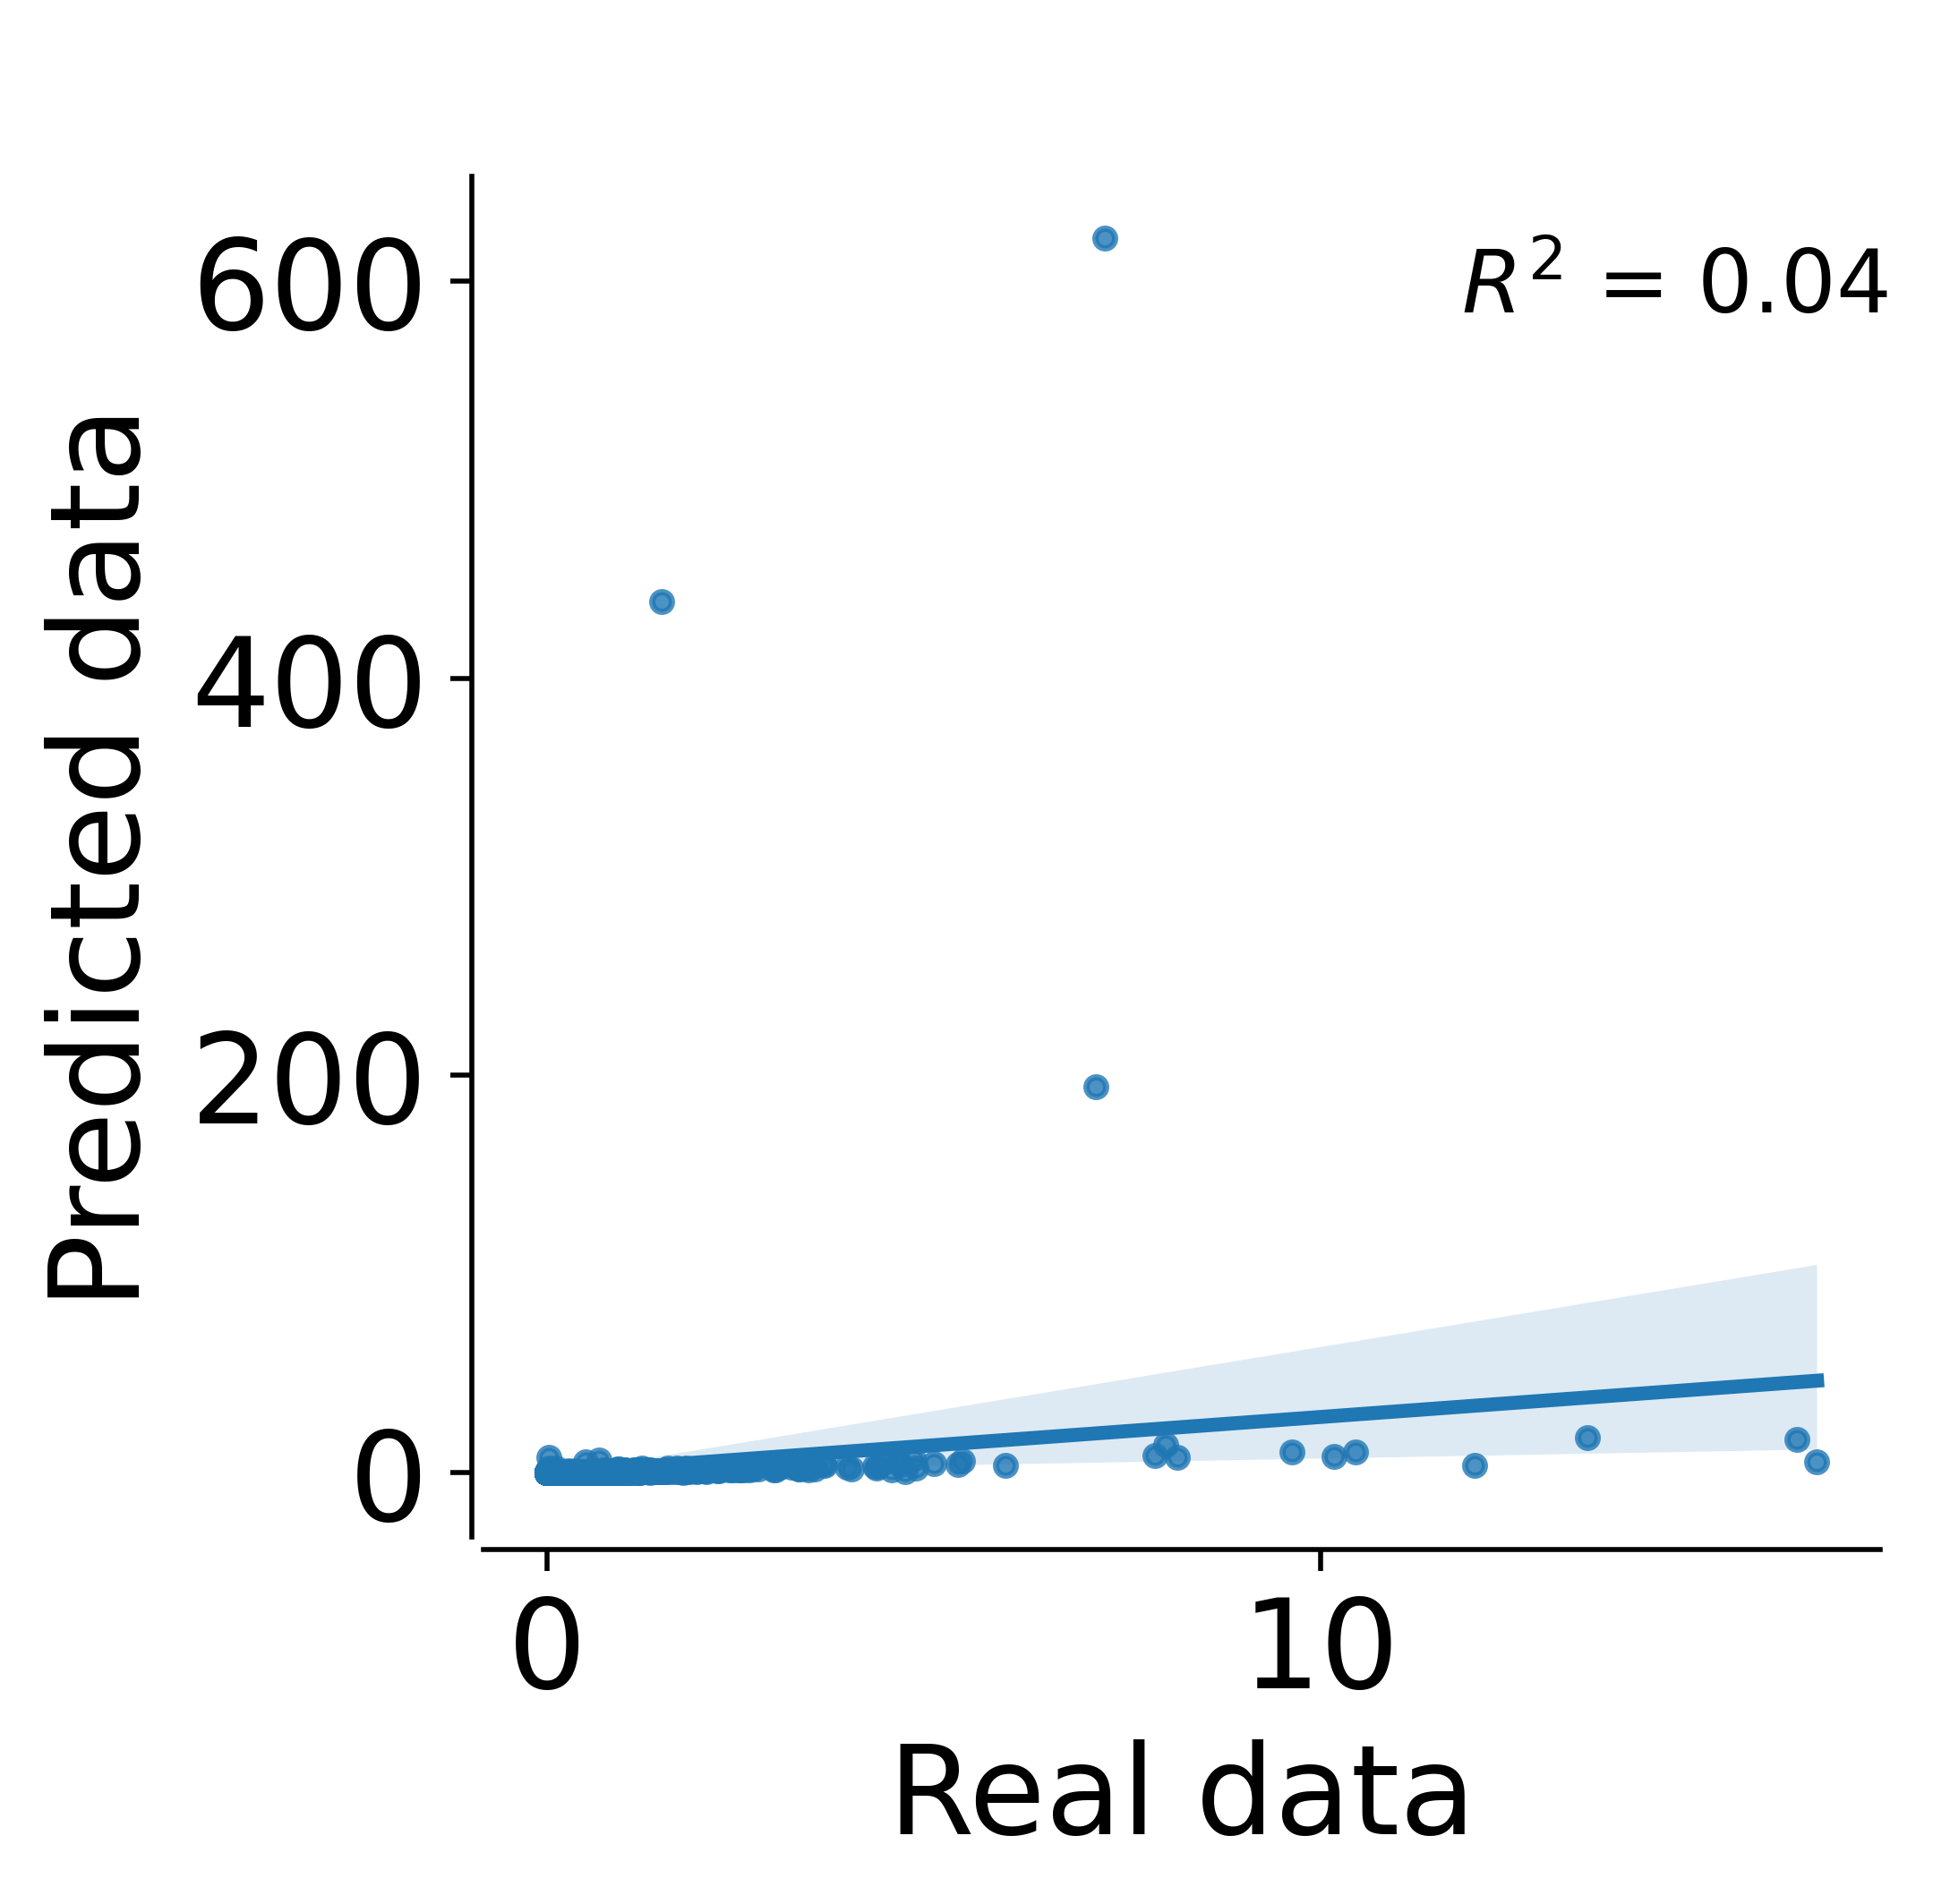

In [89]:
Plotting_Correlation_var(adata_hema_neutrophil_backward," ",pca_pal[2])


In [18]:
C_mean,C_var,M_mean,M_var = zebra_obj.Simulations(adata_test,1,0,"data")

/home/gaurav/anaconda3/envs/project/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/gaurav/anaconda3/envs/project/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/gaurav/anaconda3/envs/project/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In 

/home/gaurav/anaconda3/envs/project/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/gaurav/anaconda3/envs/project/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/gaurav/anaconda3/envs/project/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In 

/home/gaurav/anaconda3/envs/project/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/gaurav/anaconda3/envs/project/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/gaurav/anaconda3/envs/project/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In 

In [19]:
adata_hema_neutrophil_backward.uns["mean_correlations"] = C_mean
adata_hema_neutrophil_backward.uns["std_correlations"] = C_var
adata_hema_neutrophil_backward.uns["mean_slope"] = M_mean
adata_hema_neutrophil_backward.uns["std_slope"] = M_var

In [20]:
adata_hema_neutrophil_backward.write_h5ad("/home/gaurav/Gaurav/Berlin/Deep_Learning/Project/models/NB_MMD/Objects/hematopoiesis/Neutro_backward_.h5ad")